In [3]:
import pandas as pd

# Load the dataset
# If the file is in the same directory as your notebook, you can just use the filename
file_path = "nba.csv"  # Or the correct path to your file

# If the file is in a different directory, provide the full path.
# For example, if it's in your 'Downloads' folder:
# file_path = "/home/your_username/Downloads/nba.csv"  # Replace with your actual path

try:
    df = pd.read_csv(file_path)
    # Display first few rows
    df.head()
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path.")

In [4]:
# Check for missing values
print(df.isnull().sum())

# Drop player name (text attribute, not useful for prediction)
df = df.drop(columns=['Name'])

# Convert target column to binary (if not already)
df['TAR'] = df['TAR'].astype(int)

# Handle missing values using mean imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])

# Display dataset info after preprocessing
df.info()


Name     0
GP       0
MIN      0
PPT      0
FGM      0
FGA      0
FG%      0
3PM      0
3PA      0
3P%     11
FTM      0
FTA      0
FT%      0
OREB     0
DREB     0
REB      0
AST      0
STL      0
BLK      0
TOV      0
TAR      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GP      1340 non-null   int64  
 1   MIN     1340 non-null   float64
 2   PPT     1340 non-null   float64
 3   FGM     1340 non-null   float64
 4   FGA     1340 non-null   float64
 5   FG%     1340 non-null   float64
 6   3PM     1340 non-null   float64
 7   3PA     1340 non-null   float64
 8   3P%     1340 non-null   float64
 9   FTM     1340 non-null   float64
 10  FTA     1340 non-null   float64
 11  FT%     1340 non-null   float64
 12  OREB    1340 non-null   float64
 13  DREB    1340 non-null   float64
 14  REB     1340 non-null   float64
 15  AST     1340 no

In [5]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['TAR'])
y = df['TAR']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Use this for KNN and ANN models


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

knn = KNeighborsClassifier(n_neighbors=5)

# Perform 10-fold cross-validation
cv_scores_knn = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN 10-Fold CV Mean F1 Score:", cv_scores_knn.mean())
print("KNN Test F1 Score:", f1_score(y_test, y_pred_knn))


KNN 10-Fold CV Mean F1 Score: 0.714671636036298
KNN Test F1 Score: 0.7597765363128491


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 10-fold cross-validation
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest 10-Fold CV Mean F1 Score:", cv_scores_rf.mean())
print("Random Forest Test F1 Score:", f1_score(y_test, y_pred_rf))


Random Forest 10-Fold CV Mean F1 Score: 0.7456895318616505
Random Forest Test F1 Score: 0.776536312849162


In [9]:
from sklearn.linear_model import LogisticRegression

penalties = [None, 'l1', 'l2', 'elasticnet']  # Change 'none' to None
best_f1 = 0
best_penalty = None

for penalty in penalties:
    if penalty == 'elasticnet':
        solver = 'saga'  # Only saga solver supports elasticnet
        l1_ratio = 0.5   # Default balance for elasticnet
    else:
        solver = 'liblinear' if penalty in ['l1', 'l2'] else 'lbfgs'
        l1_ratio = None

    log_reg = LogisticRegression(penalty=penalty, solver=solver, l1_ratio=l1_ratio, max_iter=500)
    log_reg.fit(X_train, y_train)
    y_pred_log = log_reg.predict(X_test)
    f1 = f1_score(y_test, y_pred_log)

    print(f"Logistic Regression ({penalty}) F1 Score:", f1)

    if f1 > best_f1:
        best_f1 = f1
        best_penalty = penalty

print(f"Best Logistic Regression Regularization: {best_penalty} with F1 Score: {best_f1}")


Logistic Regression (None) F1 Score: 0.8011049723756906
Logistic Regression (l1) F1 Score: 0.8011049723756906
Logistic Regression (l2) F1 Score: 0.8055555555555556
Logistic Regression (elasticnet) F1 Score: 0.8011049723756906
Best Logistic Regression Regularization: l2 with F1 Score: 0.8055555555555556


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Ensure data is scaled (MLP is sensitive to feature scaling!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLPClassifier with better convergence settings
ann = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=2000,  # Increased for better convergence
                    random_state=42,
                    solver='adam',
                    learning_rate_init=0.001,
                    early_stopping=True)  # Stops early if no improvement

# Perform 10-fold cross-validation (separate instance to avoid refitting issues)
cv_scores_ann = cross_val_score(MLPClassifier(hidden_layer_sizes=(64, 32),
                                              max_iter=2000,
                                              random_state=42,
                                              solver='adam',
                                              learning_rate_init=0.001,
                                              early_stopping=True),
                                X_train_scaled, y_train, cv=10, scoring='f1')

# Train final ANN model
ann.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ann = ann.predict(X_test_scaled)

# Print results
print("ANN 10-Fold CV Mean F1 Score:", cv_scores_ann.mean())
print("ANN Test F1 Score:", f1_score(y_test, y_pred_ann))




ANN 10-Fold CV Mean F1 Score: 0.7615956961919668
ANN Test F1 Score: 0.7899159663865546


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {'n_estimators': [50, 100, 200]}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest F1 Score:", grid_search_rf.best_score_)


Best Random Forest Parameters: {'n_estimators': 200}
Best Random Forest F1 Score: 0.7413334277876062


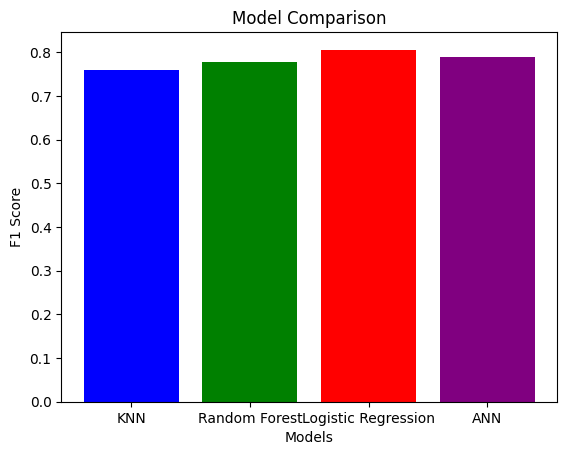

In [12]:
import matplotlib.pyplot as plt

models = ['KNN', 'Random Forest', 'Logistic Regression', 'ANN']
f1_scores = [
    f1_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_rf),
    best_f1,  # Best logistic regression result
    f1_score(y_test, y_pred_ann)
]

plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("Model Comparison")
plt.show()
